In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stat
import seaborn as sns
import scipy
from scipy.integrate import quad
from scipy.special import binom
import statsmodels.api as sm
import pylab

In [2]:
df_day = pd.read_csv('day.csv')
df_hour = pd.read_csv('hour.csv')

## Extract the Relevant Data

In [24]:
def season_hour_wrapper(df):
    """
    
    """
    df = df[df['holiday'] != 1 ]
    df = df[df['workingday'] == 1]
    df = df[df['weathersit'] < 4]
    df = df[df['hr'].isin(np.arange(16,19))]
    
    df_spring = df[df['season'] == 2]
    df_summer = df[df['season'] == 3]

    return df_spring, df_summer

df_spring, df_summer = season_hour_wrapper(df_hour)


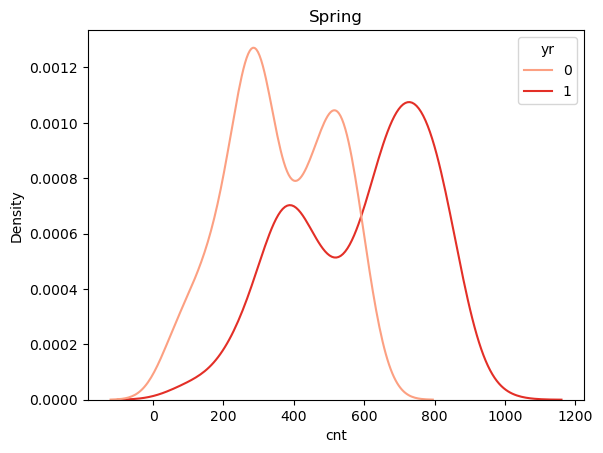

In [25]:
sns.kdeplot(x='cnt',data=df_spring, palette='Reds', hue='yr')
plt.title("Spring");


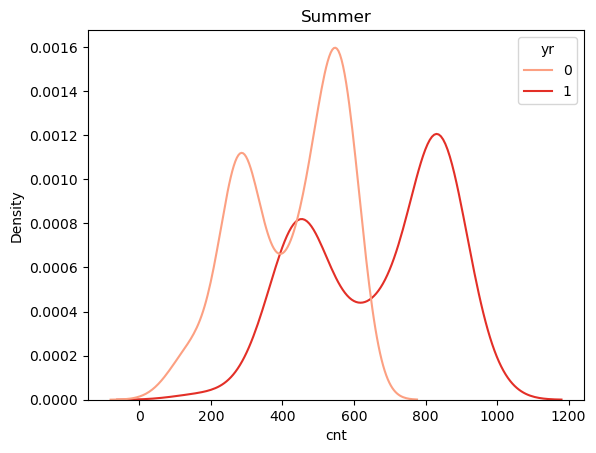

In [26]:
sns.kdeplot(x='cnt', hue='yr', data=df_summer, palette = 'Reds')
plt.title("Summer");

In [28]:
df_hour.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


In [30]:
df_hour.shape

(17379, 17)

In [31]:
def generate_quartiles(df):
    arr = np.zeros(df.shape[0])
    store_quartiles = {'windspeed' : arr, 'hum' : arr, 'weathersit' : arr, 'atemp' : arr}

    for feat in store_quartiles.keys():
        quartiles = np.zeros(df.shape[0])
        for q in [25,50,75]:
            quartiles += np.where(df[str(feat)] > np.percentile(df[str(feat)], q), 1, 0)
        
        df[f"{feat}_code"] = quartiles
    
    return df

def outlier_detection(df):
    
    fig = plt.figure(figsize= (15,10))
    plt.title('Count vs Quartiles for Continuous data', fontweight = 'bold', fontsize=15)
    for idx, x in zip(range(221,225), ['weathersit_code', 'windspeed_code', 'hum_code', 'atemp_code']):
        ax1 = fig.add_subplot(idx)
        sns.boxplot(x=x, y='cnt', data=df)
    
    plt.show()


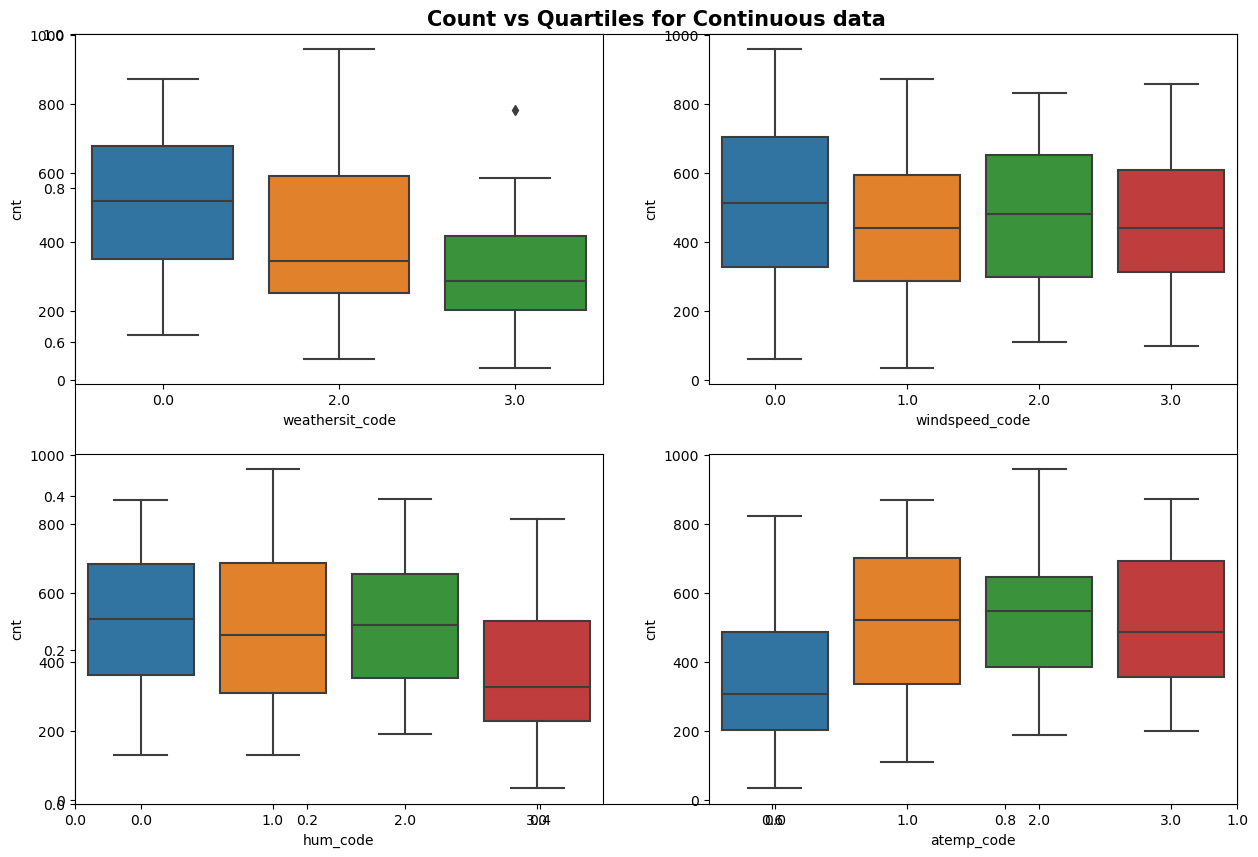

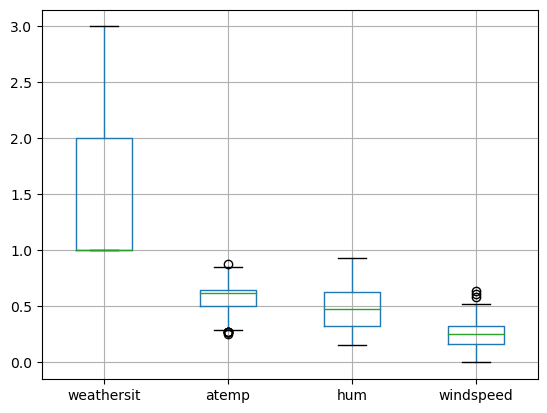

In [32]:
df_spring = generate_quartiles(df_spring)

outlier_detection(df_spring)

df_spring.boxplot(['weathersit', 'atemp', 'hum', 'windspeed']);

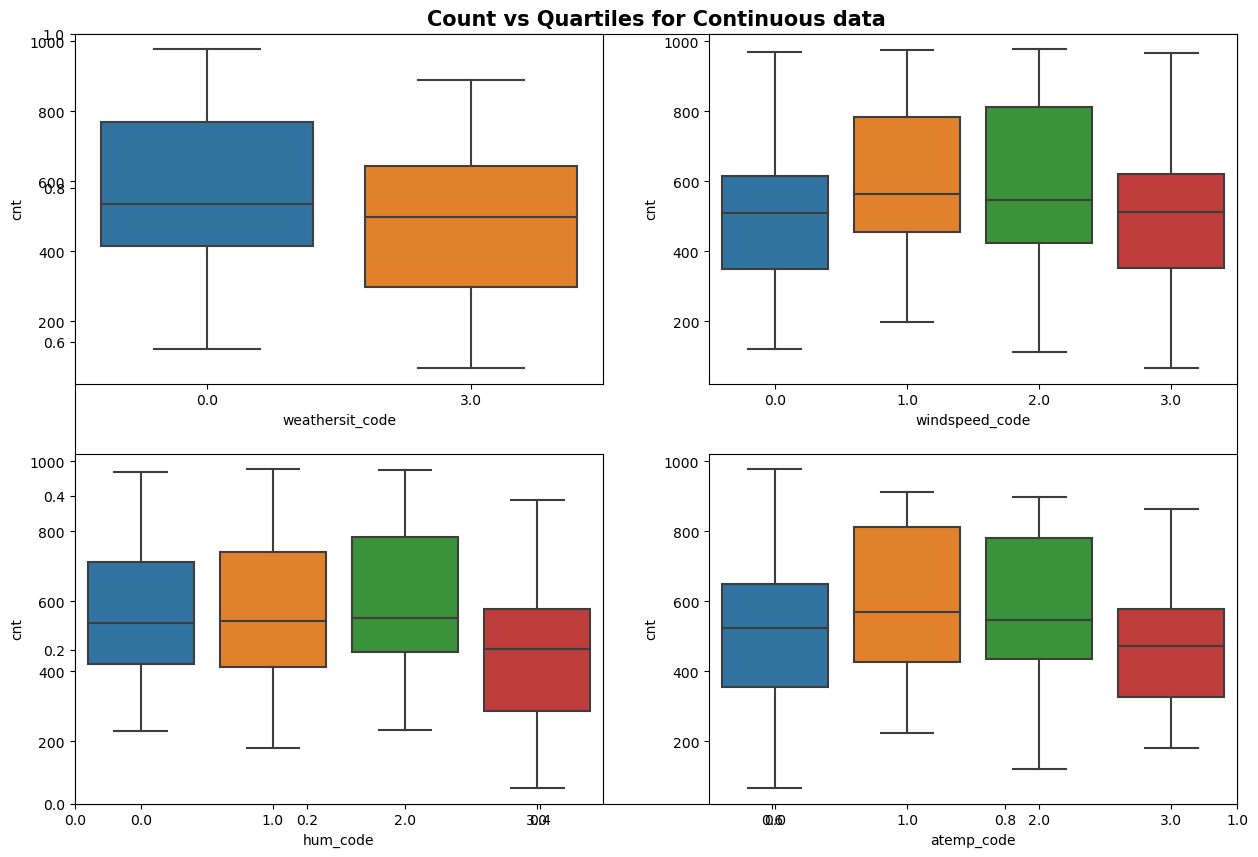

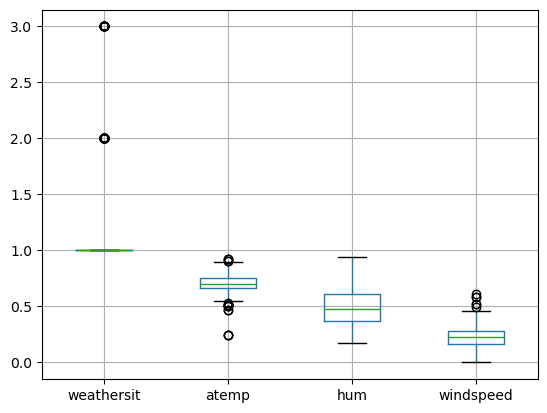

In [33]:
df_summer = generate_quartiles(df_summer)

outlier_detection(df_summer)

df_summer.boxplot(['weathersit', 'atemp', 'hum', 'windspeed']);

# Collecting and Filtering Data

In [34]:
def create_dataframes():
    return pd.read_csv('day.csv'), pd.read_csv('hour.csv')
    
def season_hour_wrapper(df):
    """
    
    """
    df = df[df['holiday'] != 1 ]
    df = df[df['workingday'] == 1]
    df = df[df['weathersit'] < 4]
    #df = df[df['windspeed'] < 0.7]
    df = df[df['hr'].isin(np.arange(16,19))]
    
    df_spring = df[df['season'] == 2]
    df_summer = df[df['season'] == 3]

    return df_spring, df_summer

def count_aggregator(df_hr):
    """ 
    
    """
    return df_hr['cnt'].groupby(df_hr['dteday']).sum()

def collect_data():
    """ 
    
    """
    _, df_hour = create_dataframes()
    df_spring, df_summer = season_hour_wrapper(df_hour)
    
    frames = {}
    frames['spring'], frames['summer'] = df_spring, df_summer
  
    for key in frames.keys():
        frames[key] = count_aggregator(frames[key])
    
    return frames

In [35]:
filtered_seasons = collect_data()

# Plotting Functions for Comparing Distributions

In [36]:
def plot_freq_hist(seasons):
    """ 
    
    """
    # / TODO improve plotting
    fig = plt.figure(figsize= (6,6))
    colors = ['r', 'b']

    for key, c in zip(seasons.keys(), colors):
        x = seasons[key]
        n = len(x)
        plt.hist(x=x, label=key, color=c, alpha=0.5, bins=15, weights = np.ones(n)/n)
    
    plt.title('Summer vs. Spring Bike Rental Counts', fontweight='bold', fontsize=15)
    plt.legend()
    plt.show()

def plot_box(seasons):
    """ 
    
    """
    # / TODO improve plotting 
    fig, ax = plt.subplots(2, figsize=(8,10))
    cnt = 0
    
    for season in ['spring', 'summer']:
        year0 = seasons[f'{season}0']
        year1 = seasons[f'{season}1']
        ax[cnt].boxplot(x=year0)
        ax[cnt].boxplot(x=year1)
        cnt += 1
    ax[0].set_title('Spring')
    ax[1].set_title('Summer')
        
    
    plt.legend()
    plt.show()
    
def qq_plot(seasons, Normalized=False):
    """ 
    
    """
    
    if Normalized:
        for key in seasons.keys():
            with plt.rc_context():
                plt.rc("figure", figsize=(5,5))
                sm.qqplot(data=seasons[key], fit=True, line = '45')
            
            plt.title(f"QQ-Plot {key} (Normalized)", fontweight='bold')
            plt.tight_layout()
    else:
        for key in seasons.keys():
            scipy.stats.probplot(seasons[key], dist="norm", plot=pylab)
            pylab.title(f"QQ-Plot {key} (Unnormalized)")
            pylab.show()

def mse(sample_cdf, normal_cdf):
    """  
    
    """
    assert(len(sample_cdf) == len(normal_cdf))
    return np.sum( (1/len(sample_cdf))*(sample_cdf - normal_cdf)**2)

def normalized_empirical_cdf(seasons):
    """ 
    
    """
    # /TODO improve plotting
    fig = plt.figure(figsize= (13,7))
    ax1 = fig.add_subplot(233)
    
    input_cdf = np.linspace(-3,3,  len(seasons.get('summer')))
    theoretical_cdf = scipy.stats.norm.cdf(input_cdf)
    
    ax1.plot(input_cdf, theoretical_cdf, label='Normal CDF')
    
    for key in seasons.keys(): 
        arr = np.array(seasons[key])
        norm_arr = scipy.stats.zscore(arr)
        norm_arr.sort()
        empirical_cdf = np.arange(1,len(norm_arr)+1)/len(norm_arr)

        ax1.plot(norm_arr, empirical_cdf,label = f'S{key[1:]} Empirical CDF')
        
        try:
            mse_error = round(mse(empirical_cdf, theoretical_cdf),4)
        
        except AssertionError:
        
            diff = abs(len(empirical_cdf) - len(theoretical_cdf))
        
            if len(theoretical_cdf) < len(empirical_cdf):
                empirical_cdf = empirical_cdf[diff:]
                norm_arr = norm_arr[diff:]
            else:
                theoretical_cdf = theoretical_cdf[diff:]
            
            mse_error = round(mse(empirical_cdf, theoretical_cdf),4)
        
        print("Mean Squared Error Empirical vs Theoretical CDF: ", mse_error)
    
    ax1.set_title(label='Empirical vs Theoretical CDF', fontweight='bold')
    
    plt.legend(loc='best')
    plt.tight_layout()

def kernel_density(seasons):
    
    colors = ['r', 'b']

    for key, c in zip(seasons.keys(), colors):
        sns.kdeplot(x=seasons[key], color=c, label = f'KDE {key}')
    plt.tight_layout()
    plt.legend()
    plt.title('Kernel Density Function')

def cum_dist(seasons):
    colors = ['r', 'b']

    for key, c in zip(seasons.keys(), colors):
        sns.histplot(x=seasons[key], color=c, label = f'CDF {key}', 
                     stat='density', bins=len(seasons[key]), fill=False, cumulative=True,
                     common_norm=False, element='step')
    plt.tight_layout()
    plt.legend()
    plt.title('Cumulative Distribution Function')

# Visual Comparison

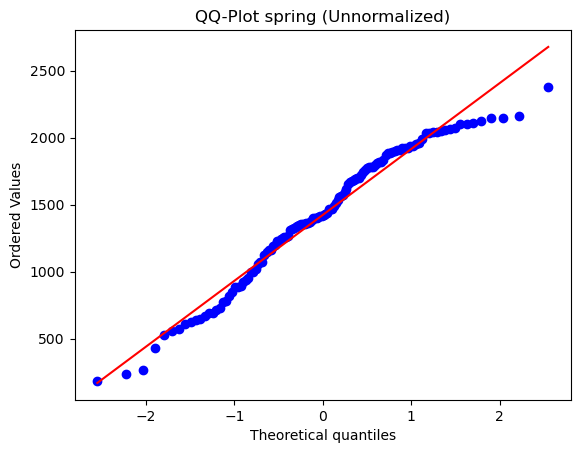

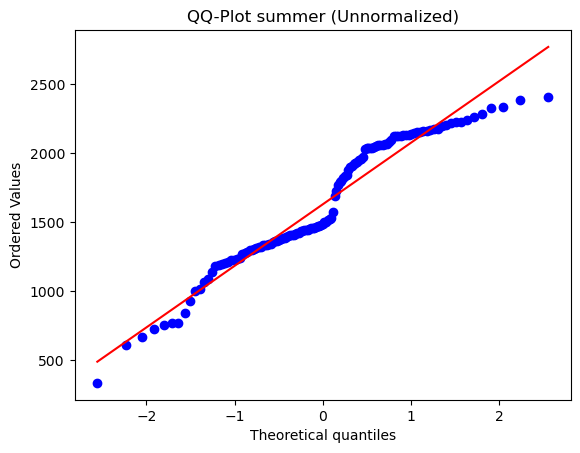

In [37]:
qq_plot(filtered_seasons)

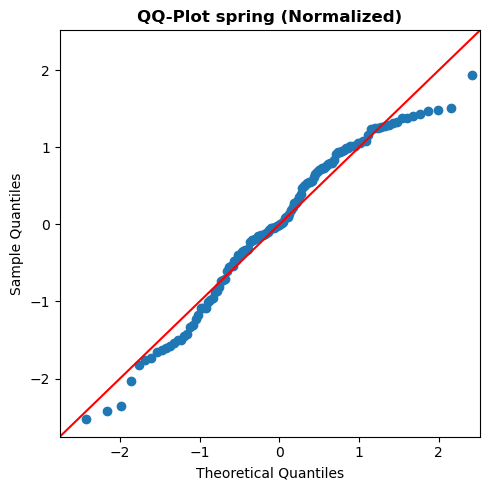

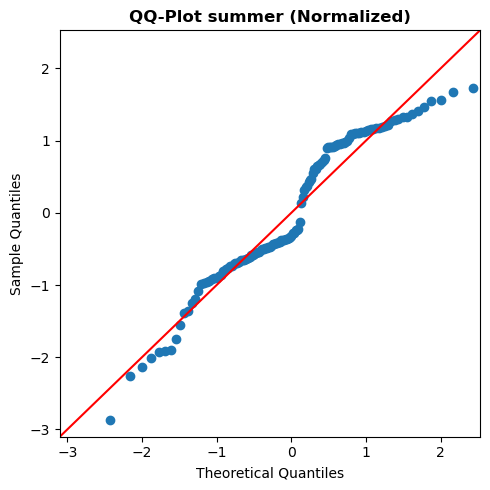

In [38]:
qq_plot(filtered_seasons, Normalized=True)

Mean Squared Error Empirical vs Theoretical CDF:  0.0165
Mean Squared Error Empirical vs Theoretical CDF:  0.0178


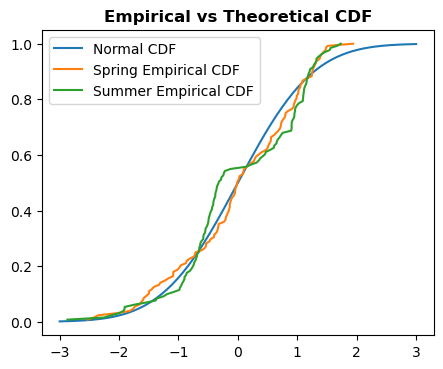

In [39]:
normalized_empirical_cdf(filtered_seasons)

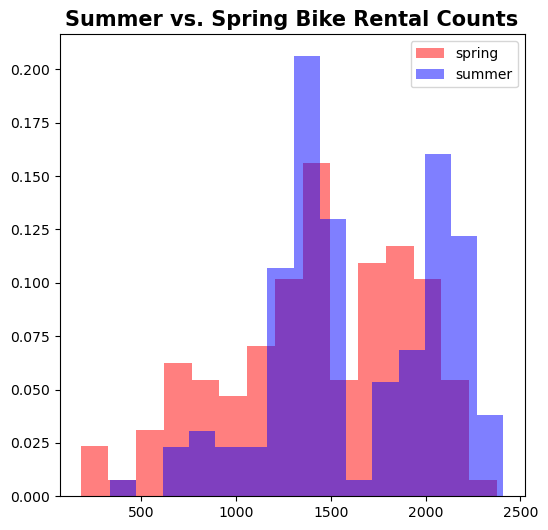

In [40]:
plot_freq_hist(filtered_seasons)

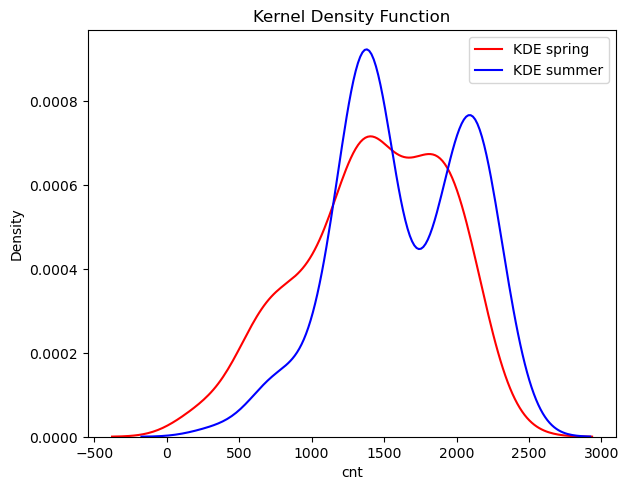

In [41]:
kernel_density(filtered_seasons)

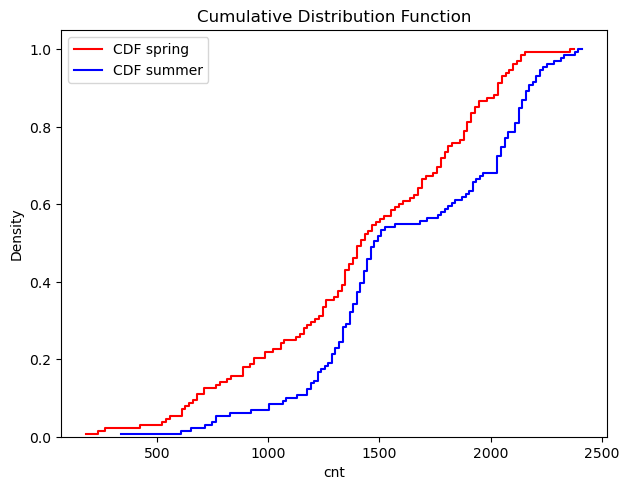

In [42]:
cum_dist(filtered_seasons)

# Shapiro-Wilk Test
inspired by https://math.mit.edu/~rmd/465/shapiro.pdf

In [43]:
def norm_expectation_rank(r, n):
    """ 
    
    """
    inf, phi, Phi = float('inf'), stat.NormalDist().pdf, stat.NormalDist().cdf
    def f(x):

        F = Phi(x)
        return x*(1-F)**(r-1)*F**(n-r)*phi(x)
    return r*binom(n, r)*quad(f, -inf, inf)[0]

def expected_val_arr(arr, dict_return=False):
    n = len(arr)
    if not dict_return:
        return np.array([norm_expectation_rank(k+1, n+1) for k in range(n)])
    else:
        return {f"expected val rank {k+1}" : norm_expectation_rank(k+1, n+1) for k in range(n)}

def cov_matrix(arr):
    n = len(arr)
    # TODO confirm covariance matrix
    # see https://apps.dtic.mil/dtic/tr/fulltext/u2/a053857.pdf
    # this requires a tedious implementation which I don't consider worthwhile
    
    return np.eye(N=len(arr), M=len(arr))

def test_statistic(seasons):
    for key in seasons.keys():
        
        x = np.array(seasons[key])
        # normalize
        x = (x - np.mean(x))/ np.std(x)
        x.sort()
        
        assert(np.isclose(np.mean(x), 0))
        assert(np.isclose(np.std(x), 1))

        n = len(x)
        # TODO inspect correctness in this function
        m = expected_val_arr(x)
        
        # Covariance matrix is incorrect, need to investigate how to calculate.
        # see TODO under function
        V = cov_matrix(m)
        
        assert(V[i][j] == V[j][i] for i in range(n) for j in range(n))
        
        normalizing_const = np.sqrt(m.T @ np.linalg.inv(V) @ np.linalg.inv(V) @ m)
        
        a = m.T @ np.linalg.inv(V) / normalizing_const
        W = (x @ a)**2 / np.sum( (x - np.mean(x))**2 )
        
        print(str.capitalize(key))
        print("Sum a: ", np.sum(a))
        print("Sum m: ", np.sum(m))
        print(f"Lower bound = {(n*(a[0]**2))/(n+1)}")
        print(f"Wilk test statistic = {W}\n")


test_statistic(filtered_seasons)


Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.9770968210121826

Summer
Sum a:  0.23533213574797163
Sum m:  2.605274439525246
Lower bound = 0.05496165946331171
Wilk test statistic = 0.9524844136198254



# Kolmogorov-Smirnov Test
inspired by http://www.math.utah.edu/~davar/ps-pdf-files/Kolmogorov-Smirnov.pdf 

(To be developed)

In [44]:
for key in filtered_seasons.keys():
    print(str.capitalize(key))
    print(scipy.stats.shapiro(filtered_seasons[key]))
    print(scipy.stats.kstest(filtered_seasons[key], scipy.stats.norm.pdf(filtered_seasons[key])), '\n')
    

Spring
ShapiroResult(statistic=0.96770179271698, pvalue=0.0037675241474062204)
KstestResult(statistic=1.0, pvalue=3.467010376606315e-76) 

Summer
ShapiroResult(statistic=0.944150984287262, pvalue=3.866817496600561e-05)
KstestResult(statistic=1.0, pvalue=5.480196336089349e-78) 

